In [161]:
include("../code/julia/ha-trade-environment.jl")
include("../code/julia/ha-trade-solution.jl")
include("../code/julia/ha-trade-helper-functions.jl")
include("../code/julia/ha-trade-elasticity.jl")
include("../code/julia/ha-trade-efficient.jl")
include("../code/julia/static-trade-environment.jl")
include("../code/julia/gravity-tools.jl")

using MINPACK
using Plots
using CSV
using DataFrames

### Set Parameters

Parameters are subdivided into two groups. One relates specifically to households, then the second relates to country-specific and/or aggregate things.

In [162]:
γ = 1.5
σϵ = 0.25
Ncntry = 2

# this setups up parameters on the household side
hh_prm = household_params(Ncntry = Ncntry, Na = 100, β = 0.92, γ = γ, ϕ = 0.5, amax = 8.0, σϵ = σϵ);

In [163]:
TFP = [1.0; 1.0]
L = [1.0; 1.0]

d_ij = 1.75

d = [1.0 d_ij; d_ij 1.0]

# this sets up the country specific paramters
cntry_prm = country_params(Ncntry = Ncntry, L = L, d = d, TFP = TFP)

country_params
  Ncntry: Int64 2
  TFP: Array{Float64}((2,)) [1.0, 1.0]
  L: Array{Float64}((2,)) [1.0, 1.0]
  d: Array{Float64}((2, 2)) [1.0 1.75; 1.75 1.0]


---

### Find an equilibrium 

Does what it says. Here I'm computing one for financial globalization. 

In [164]:
f(x) = world_equillibrium_FG(exp.(x), hh_prm, cntry_prm)

function f!(fvec, x)

    fvec .= f(x)

end


xguess = [1.0; 1.02]

n = length(xguess)
diag_adjust = n - 1

sol = fsolve(f!, log.(xguess), show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-10,
       )

print(sol)

wage = [exp.(sol.x[1]); 1.0]
R = exp.(sol.x[2])

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.803330e+00     0.000000e+00         2.620000
     2     5.004946e+00     5.050225e-03         0.531000
     3     8.336086e-02     4.076100e-03         0.179000
     4     2.266450e-01     1.733448e-05         0.204000
     5     3.080832e-02     3.550678e-05         0.203000
     6     4.369609e-03     1.718561e-07         0.204000
     7     3.339473e-04     2.336873e-09         0.193000
     8     3.974760e-07     1.196807e-11         0.218000
     9     1.305884e-08     7.963843e-17         0.191000
    10     1.267187e-10     2.535963e-20         0.207000
    11     2.776945e-14     2.456525e-24         0.197000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [0.0, 0.01980262729617973]
 * Zero: [-6.221830340655124e-9, 0.04715754357133005]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estim

1.0482871469720207

Then here are the results. The first entry is the wage rate which should be 1.0 given the symmetry. The second price is the interest rate, here it should be around 1.5 percent.

In [165]:
println(exp.(sol.x))


[0.9999999937781697, 1.0482871469720207]


Then this call computes aggregates given prices

In [166]:
Rsol = [R; R]

Y, tradeflows, A_demand, tradeshare, hh, dist = world_equillibrium(Rsol, wage, hh_prm, cntry_prm, tol_vfi = 1e-10);

In [167]:
tradeshare

2×2 Matrix{Float64}:
 0.827311  0.172689
 0.172689  0.827311

### Compute Elasticities

Here is what I'm going to do, given the equilibrium prices, I'm going to construct the trade elasticities and aggregate up, per Proposition 3 in the paper. The first step is to reconstruct the household for one country, evaluate how things change at the micro-level, then appropriately aggregate. 


In [168]:
cntry = 1 # this is the country I'll look at

p = (wage[1:end] ./ TFP).*d[cntry,:] 
# prices from the perspective of those in that country

hh = solve_household_problem(R, wage[cntry], p, hh_prm, tol = 1e-10);
# solve hh problem at those prices

dist = make_stationary_distribution(hh, hh_prm);
# find stationary distribution


This cell below then constructs the elasticities via numerical differentiation. Then the last two function calls construct the weights and then aggregate.

A note on accuracy. I don't have a closed form for this. But in Mongey and Waugh, we do. And their I found that this approach worked well with the only issues being around states where the household is about to leave the borrowing constraint. This is to be expected per my discussion in the paper regarding how the constraint might show up in the elasticities.

In [169]:
θ = make_θ(hh, cntry, R, wage[cntry], p, hh_prm; points = 3, order = 1)

ω = make_ω(hh, dist, L[cntry], p, hh_prm)

agθ = aggregate_θ(θ, ω, cntry, hh_prm)

2-element Vector{Float64}:
  1.0
 -2.8728095601247703

A quick tour of the results:

Here is the aggregate elasticity. In this situation it's about 3. What if the trade costs was larger?

In [170]:
agθ[2]

-2.8728095601247703

Then here we can look at the micro-elasticities. The θ is a structure and contains the intensive margin, extensive margin, and how home stuff changes with respect to a change in prices. The first one is how θ_{ij}^E looks state by state where one see high extensive margin elasticities for stuff in the upper-left corner of the matrix (poor people) and hten in the lower-right corner the elasticities are low (rich people)

In [171]:
θ.θπ[:,:,2] # get extensive margin elasticities

100×10 Matrix{Float64}:
 -11.4895   -7.18135  -8.54226  -5.43687  …  -2.80168  -2.47028  -2.19723
  -9.39148  -6.69669  -7.56336  -4.84634     -2.7515   -2.44386  -2.18518
  -6.98896  -5.94415  -5.56687  -4.69037     -2.71063  -2.3803   -2.17599
  -6.51976  -5.5688   -5.3147   -4.45292     -2.67825  -2.32251  -2.16475
  -5.85196  -5.37458  -4.78477  -4.2704      -2.64923  -2.29537  -2.15395
  -5.5023   -5.12719  -4.52203  -4.13459  …  -2.62325  -2.27334  -2.14356
  -5.22047  -4.94038  -4.40113  -4.05578     -2.60608  -2.25457  -2.13349
  -5.0713   -4.77564  -4.22826  -3.94237     -2.58325  -2.23851  -2.12372
  -4.89261  -4.63749  -4.09844  -3.85532     -2.56212  -2.22382  -2.11421
  -4.7344   -4.54318  -3.98145  -3.77733     -2.54229  -2.21021  -2.10495
  -4.60362  -4.43318  -3.89015  -3.70756  …  -2.52308  -2.19746  -2.0959
  -4.48746  -4.3344   -3.83069  -3.64478     -2.50537  -2.185    -2.08707
  -4.38366  -4.24588  -3.75502  -3.5873      -2.48846  -2.17581  -2.07843
   ⋮           

Then one sees the same thing on the intensive margin. Note that at the top of the asset grid, the behavior goes in different direction. But this is because at that point, there is no where for the household to go. And these guys are like near zero.

In [172]:
θ.θc[:,:,2]

100×10 Matrix{Float64}:
 -1.0       -0.819574  -1.0       …  -0.641527  -0.63685   -0.591728
 -1.0       -0.816915  -1.0          -0.634519  -0.63408   -0.590431
 -0.818509  -0.762643  -0.809538     -0.629236  -0.619506  -0.589911
 -0.816086  -0.741741  -0.806251     -0.625235  -0.609289  -0.588745
 -0.761233  -0.73822   -0.747505     -0.621843  -0.604624  -0.587665
 -0.740388  -0.723259  -0.725547  …  -0.619007  -0.601269  -0.586653
 -0.724871  -0.713376  -0.722383     -0.61813   -0.598643  -0.585696
 -0.722356  -0.70424   -0.706237     -0.615713  -0.596534  -0.584787
 -0.712512  -0.697516  -0.695937     -0.61356   -0.594721  -0.58392
 -0.703386  -0.695488  -0.686238     -0.611629  -0.593136  -0.58309
 -0.696749  -0.689714  -0.679747  …  -0.609881  -0.591718  -0.582294
 -0.690895  -0.684639  -0.677933     -0.608268  -0.590421  -0.581528
 -0.685758  -0.680308  -0.672254     -0.606766  -0.589901  -0.580789
  ⋮                               ⋱                        
 -0.589804  -0.588979

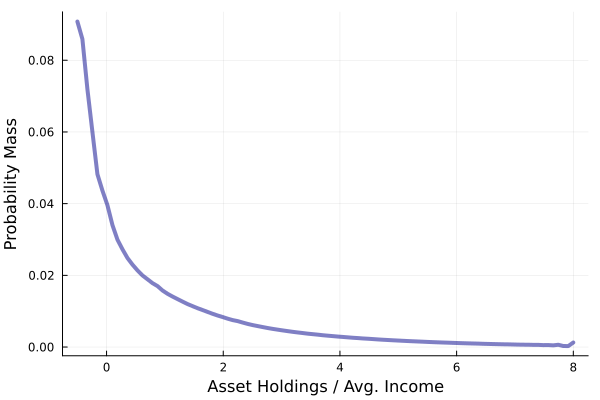

In [173]:
adist = get_distribution(dist.state_index, dist.λ);

plot(foo.agrid , adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", 
    xlabel = "Asset Holdings / Avg. Income", label = false)